In [1]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from ballmapper.pyBallMapper import BallMapper

import catboost as cb

In [2]:
def generate_tpf(n=100, sigma=0.1, dgp=ss.uniform()):
    norm = ss.norm(loc=0, scale=sigma)
    x = dgp.rvs(n)
    def tpf_(t):
        if t<0.3: return 2*t
        if t>0.7: return 1.4-t # perhaps 1.3-t?
        return 0.6
    y = list(map(tpf_, x))
    y += norm.rvs(n)
    return x, y

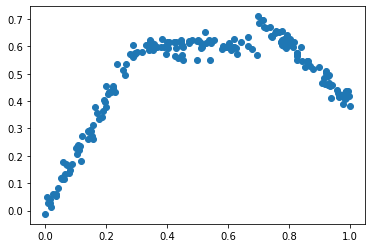

In [3]:
x, y = generate_tpf(n=200, sigma=0.02)
plt.plot(x, y, 'o')

In [15]:
def rmse_ols(n, sigma, mcloops=1000, dgp=ss.uniform()):
    rmses = []
    for mcloop in range(mcloops):
        x, y = generate_tpf(n=n, sigma=sigma, dgp=dgp)
        X = x.reshape(-1,1)
        lm = LinearRegression().fit(X,y)
        rmse = mean_squared_error(lm.predict(X), y, squared=False)
        rmses.append(rmse)
    return np.mean(rmses) 

In [16]:
sigmas = [0.02, 0.2, 0.5]
ns = [200, 500, 1000, 2000]
mcloops = 1000
rmses = []
for sigma in sigmas:
    for n in ns:
        rmses.append([sigma, n, rmse_ols(n=n, sigma=sigma, mcloops=mcloops, dgp=ss.norm())])

In [17]:
pd.DataFrame(rmses, columns=['sigma', 'n', 'OLS'])

,sigma,n,OLS
0,0.02,200,0.790889
1,0.02,500,0.802234
2,0.02,1000,0.803905
3,0.02,2000,0.803835
4,0.20,200,0.817820
5,0.20,500,0.826530
6,0.20,1000,0.828292
7,0.20,2000,0.828714
8,0.50,200,0.940158
9,0.50,500,0.944203


In [4]:
class BMLR:
    def __init__(self, epsilon, cut, M, substitution_policy = 'global'):
        self.epsilon = epsilon
        self.cut = cut
        self.M = M
        self.substitution_policy = substitution_policy
        self.npts = None
        self.dpts = None
        self.lm_global = LinearRegression()
        self.ball_mappers = []
        self.in_sample_remse = None
        self.fitted = False
        
        
    def fit(self, x, y):
        self.npts = x.shape[0]
        self.dpts = x.shape[1]
        self.ball_mappers = []
        self.fitted = True
        # fit global model
        if self.substitution_policy == 'global':
            self.lm_global.fit(x,y)
        
        for r_ in range(self.M):
            bm = BallMapper(points=x, coloring_df=pd.DataFrame(y), epsilon=self.epsilon, shuffle=True)
            self.ball_mappers.append(bm)
            for node_id in bm.Graph.nodes:
                ball_pts_ind = bm.Graph.nodes[node_id]['points covered']
                if len(ball_pts_ind) >= self.cut:
                    x_ball = x[ball_pts_ind, :]
                    y_ball = y[ball_pts_ind]
                    lm = LinearRegression().fit(x_ball, y_ball)
                    bm.Graph.nodes[node_id]['beta'] = lm.coef_
                    bm.Graph.nodes[node_id]['intercept'] = lm.intercept_
                else:
                    if self.substitution_policy == 'global':
                        bm.Graph.nodes[node_id]['beta'] = self.lm_global.coef_
                        bm.Graph.nodes[node_id]['intercept'] = self.lm_global.intercept_
                    else:
                        # find nearest big ball
                        min_dist = np.Inf
                        min_id = None
                        small_ball_mean = np.mean(x[ball_pts_ind, :], axis=0)
                        for big_node_id in bm.Graph.nodes:
                            big_pts_ids = bm.Graph.nodes[big_node_id]['points covered']
                            if len(big_pts_ids) >= self.cut:
                                big_ball_mean = np.mean(x[big_pts_ids, :], axis=0)
                                dist = np.linalg.norm(small_ball_mean - big_ball_mean)
                                if dist < min_dist:
                                    min_dist = dist
                                    min_id = big_node_id
                        # make Linear Model in big ball
                        # TODO: This could be rearrange
                        # 1. first build models only in big-balls
                        # 2. iterate over small balls and copy the model from big balls
                        # thanks to that we don't have to fit linear model inside big-balls multiple times
                        if min_id == None:
                            raise ValueError(f'All ball contain less than cut={self.cut} points. Decrease cut or increase epsilon!')
                        big_pts_ids = bm.Graph.nodes[min_id]['points covered']
                        lm_big = LinearRegression().fit(x[big_pts_ids, :], y[big_pts_ids])
                        bm.Graph.nodes[node_id]['beta'] = lm_big.coef_
                        bm.Graph.nodes[node_id]['intercept'] = lm_big.intercept_    

                
    def predict(self, x_test):
        if not self.fitted:
            raise ValueError('Cannot run predict(). Run fit() first')
        
        npts_test = x_test.shape[0]
        
        yhat = [0] * npts_test   # TODO: change list to array
        counts = [0] * npts_test # TODO: change list to array

        n_Nones = 0
        
        # iterate over all mappers
        for bm in self.ball_mappers:
            # get a list of nodes to which all test points belongs
            # for each point a list of nodes ids is returned
            ball_idxs = bm.find_balls(x_test, nearest_neighbour_extrapolation=True)
            # loop over balls to which all test points belongs, this is in fact loop over test points
            for pt_id, ball_idx in enumerate(ball_idxs):
                xp = x_test[pt_id, :]
                if ball_idx[0] is not None:
                    #print(ball_idx)
                    # given test point can belong to many balls, loop over all of those
                    # each of these balls covers several points from the trainig set
                    # here we get a list of training points ids
                    for node_idx in ball_idx:
                        yhat[pt_id] += np.matmul(bm.Graph.nodes[node_idx]['beta'], xp) + bm.Graph.nodes[node_idx]['intercept']
                        counts[pt_id] += 1.0
                else:
                    n_Nones += 1
        yhat = np.array(yhat)
        counts = np.array(counts)
        # print(yhat)
        #print(counts)
        #print(yhat)
        #print(n_Nones)
        yhat /= counts
        #print(yhat)
        return yhat
        
    def score(self, x, y):
        yhat = self.predict(x)
        rmse = mean_squared_error(yhat, y, squared=False)
        return rmse

In [15]:
# some test
x, y = generate_tpf(n=200, sigma=0.02)
x_test, y_test = generate_tpf(n=40, sigma=0.02)
x = x.reshape(-1,1)
x_test = x_test.reshape(-1,1)

In [31]:
bmlr = BMLR(epsilon=0.1, cut=0, M=5, substitution_policy='global')
bmlr.fit(x,y)
# this should be the same as bmlr.in_sample_remse
print(bmlr.score(x, y))
print(bmlr.score(x_test, y_test))

0.022517611767426185
0.020071113454161783


In [8]:
mcloops = 10
cut = 25
M = 20
#dgp = ss.uniform()
dgp = ss.norm()

rmses = []
epsilon_list = np.linspace(0.2, 2, 10)
for epsilon in epsilon_list:
    print(f'epsilon={epsilon}')
    rmses_epsilon = []
    for mcloop in range(mcloops): 
        x_train, y_train = generate_tpf(n=200, sigma=0.02, dgp=dgp)
        x_test, y_test = generate_tpf(n=40, sigma=0.02, dgp=dgp)
        x_train = x_train.reshape(-1,1)
        x_test = x_test.reshape(-1,1)

        bmlg = BMLR(epsilon=epsilon, cut=cut, M=M, substitution_policy='global')
        bmln = BMLR(epsilon=epsilon, cut=cut, M=M, substitution_policy='nearest')
        bmlg.fit(x_train, y_train)
        bmln.fit(x_train, y_train)

        rmseg_in  = bmlg.score(x_train, y_train)
        rmseg_out = bmlg.score(x_test, y_test)
        rmsen_in  = bmln.score(x_train, y_train)
        rmsen_out = bmln.score(x_test, y_test)
        
        # train catboost
        train_dataset = cb.Pool(x_train, y_train)
        test_dataset = cb.Pool(x_test, y_test)
        model = cb.CatBoostRegressor(loss_function='RMSE')
        model.fit(train_dataset, eval_set=test_dataset, use_best_model=True, verbose=0)
        cb_score = model.best_score_['validation']['RMSE']
        
        rmses_epsilon.append([rmseg_in, rmsen_in, rmseg_out, rmsen_out, cb_score])
    
    rmses_epsilon = np.mean(rmses_epsilon, axis=0)
    rmses.append([epsilon, *rmses_epsilon])

epsilon=0.2
epsilon=0.4
epsilon=0.6000000000000001
epsilon=0.8
epsilon=1.0
epsilon=1.2
epsilon=1.4000000000000001
epsilon=1.6
epsilon=1.8
epsilon=2.0


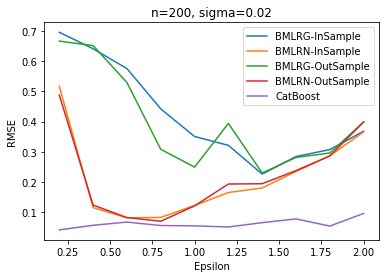

In [9]:
rmses = np.array(rmses)
plt.plot(rmses[:, 0], rmses[:, 1], label='BMLRG-InSample')
plt.plot(rmses[:, 0], rmses[:, 2], label='BMLRN-InSample')
plt.plot(rmses[:, 0], rmses[:, 3], label='BMLRG-OutSample')
plt.plot(rmses[:, 0], rmses[:, 4], label='BMLRN-OutSample')
plt.plot(rmses[:, 0], rmses[:, 5], label='CatBoost')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')
plt.title('n=200, sigma=0.02')
plt.legend()

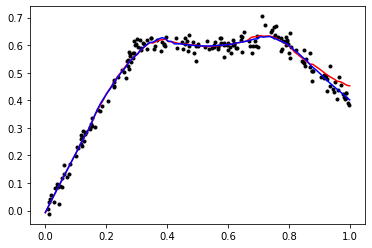

In [90]:
# make some plots
cut = 25
M = 20
xt = np.linspace(0, 1, 100)
xt = np.array(xt).reshape((-1,1))
X, y = generate_tpf(n=200, sigma=0.02)
X = X.reshape((-1,1))

bmlg = BMLR(epsilon=0.12, cut=cut, M=M, substitution_policy='global')
bmln = BMLR(epsilon=0.12, cut=cut, M=M, substitution_policy='nearest')
bmlg.fit(X, y)
bmln.fit(X, y)

yg = bmlg.predict(xt)
yn = bmln.predict(xt)
plt.plot(X, y, 'o', markersize=3, color='black')
plt.plot(xt, yg, label='BMLRG', color='red')
plt.plot(xt, yn, label='BMLRN', color='blue')

# Test model using 3d hyperplane (no noise)
Coefficiants in each ball should be the same and have the same values as in data generating process 

In [239]:
def generate_plane(n=100):
    x = ss.uniform.rvs(size=(n,3))
    y = x[:, 0]*0.34 + x[:, 1]*0.11 + x[:, 2]*(-1.234) + 0.8
    return x, y

In [249]:
sample_x, sample_y = generate_plane(2000)
bmln_hyperplane = BMLR(epsilon=0.2, cut=5, M=1, substitution_policy='nearest')
bmln_hyperplane.fit(sample_x, sample_y)
score = bmln_hyperplane.score(sample_x, sample_y)
print(score) # this should be close to 0

1.4044532940775722e-16


In [251]:
# coefficients here should be the same as in generate
print(bmln_hyperplane.ball_mappers[0].Graph.nodes[3]['beta'])
print(bmln_hyperplane.ball_mappers[0].Graph.nodes[3]['intercept'])

[ 0.34   0.11  -1.234]
0.7999999999999994


# Test model using multimodal functions
We study functions typically used to test optimization problems.
Here we go with [Himmelblau's function](https://en.wikipedia.org/wiki/Himmelblau%27s_function)

In [267]:
def generate_Himmelblau(n=100, sigma=0.1):
    norm = ss.norm(loc=0, scale=sigma)
    x = (ss.uniform.rvs(size=(n, 2))-0.5)*5*2
    y = (x[:, 0]**2 + x[:, 1] - 11)**2 + (x[:, 0] + x[:, 1]**2 - 7)**2
    #y += norm.rvs(n)
    return x, y

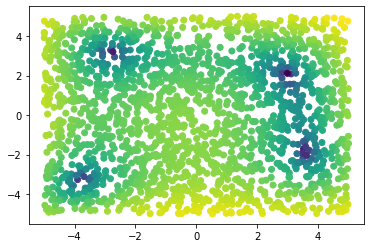

In [439]:
sample_x, sample_y = generate_Himmelblau(n=2000)
sample_x_test, sample_y_test = generate_Himmelblau(n=500)
plt.scatter(sample_x[:, 0], sample_x[:, 1], c=np.log(sample_y))

In [453]:
rf = RandomForestRegressor(n_estimators = 3000, random_state = 42)
rf.fit(sample_x, sample_y)
pred = rf.predict(sample_x_test)
rf_score = mean_squared_error(pred, sample_y_test, squared=False)
print(rf_score)

10.327965281295047


In [451]:
train_dataset = cb.Pool(sample_x, sample_y)
test_dataset = cb.Pool(sample_x_test, sample_y_test)

model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0)
model.fit(train_dataset)
pred = model.predict(test_dataset)
cb_score = mean_squared_error(pred, sample_y_test, squared=False)
print(cb_score)

4.1828264969062845


In [458]:
# test various epsilons. This is quite good accually - we get result better than Random Forrest and CatBoost
for epsilon in np.linspace(0.3, 2, 10):
    bmln_himmmel = BMLR(epsilon=epsilon, cut=10, M=10, substitution_policy='nearest')
    bmln_himmmel.fit(sample_x, sample_y)
    bmln_himmmel_score = bmln_himmmel.score(sample_x_test, sample_y_test)
    print(f'epsilon={epsilon} rmse={bmln_himmmel_score}')

epsilon=0.3 rmse=58.10030219773735
epsilon=0.4888888888888889 rmse=6.810803159387556
epsilon=0.6777777777777778 rmse=4.049133337824078
epsilon=0.8666666666666667 rmse=4.805441429383475
epsilon=1.0555555555555556 rmse=6.653900948278484
epsilon=1.2444444444444445 rmse=9.360698779774792
epsilon=1.4333333333333333 rmse=11.852183808623087
epsilon=1.6222222222222222 rmse=13.934953804199314
epsilon=1.8111111111111111 rmse=18.893126871543526
epsilon=2.0 rmse=21.494586975479116


# Train on Boston dataset

In [278]:
# Test model on some real data and benchmark it against catboost
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

boston_dataset = load_boston()

In [429]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [430]:
# get rid of data with too constant values, for simplicity of too high variance
X = boston.drop(['ZN', 'CHAS', 'RAD', 'TAX', 'B'], axis=1)
y = boston_dataset.target

In [371]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train_dataset = cb.Pool(X_train, y_train)
# test_dataset = cb.Pool(X_test, y_test)

# model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0)
# model.fit(train_dataset)
# pred = model.predict(X_test)
# cb_score = mean_squared_error(pred, y_test, squared=False)
# print(cb_score)

In [282]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train_scaled, y_train)
pred = rf.predict(X_test_scaled)
rf_score = mean_squared_error(pred, y_test, squared=False)
print(rf_score)

4.6757280694676755


In [283]:
train_dataset = cb.Pool(X_train_scaled, y_train)
test_dataset = cb.Pool(X_test_scaled, y_test)

model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0)
model.fit(train_dataset)
pred = model.predict(test_dataset)
cb_score = mean_squared_error(pred, y_test, squared=False)
print(cb_score)

4.784769267939998


In [398]:
bmln_boston = BMLR(epsilon=3, cut=10, M=1, substitution_policy='nearest')
bmln_boston.fit(X_train_scaled, y_train)
bmln_boston_score = bmln_boston.score(X_test_scaled, y_test)
print(bmln_boston_score) # sometime the RMSE goes crazy high

2336037054768.1206
